In [29]:
import matplotlib.colors as mcolors
from collections import defaultdict
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pybedtools
from pathlib import Path
import sys

In [5]:
matplotlib.font_manager.fontManager.addfont(f"{Path.cwd().parent}/font/Arial.ttf")
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [3]:
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"

In [30]:
sys.path.append(f"{PROJECT_DIR_s}6_call_motifs/")
import call_motifs_script

# Proportion of TREs with motifs

In [6]:
s = "HCT116"
model_type = "strand_merged_umap"
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]

In [7]:
# Focus on counts

motifs = {"SP": 0,
		  "ETS": 1,
		  "AP1": 2,
		  "NFY": 3,
		  "CREB": 4,
		  "NRF1": 5,
		  "YY1": 6,
		  "CTCF": 8,
		  "ZNF143": 9,
		  "ZBTB33": 11,
		  "TATA": 22
		 }

In [8]:
mapping = {}
for motif in motifs:
	mapping[f"pos_patterns.pattern_{motifs[motif]}"] = motif

In [86]:
motif_peaks = {}
df_hits = {}
for p in ps:
	motif_peaks[p] = defaultdict(set)
	dfs = []
	for d in ds:
		df = pd.read_table(f"{PROJECT_DIR_o}procapnet/finemo/{s}_{p}_{d}/hits.tsv")
		df["motif"] = df["motif_name"].map(mapping)
		df = df.dropna()
		dfs.append(df)
		for _, row in df.iterrows():
			motif_peaks[p][row["motif"]].add(row["peak_name"])
	outputfile = f"{PROJECT_DIR_o}procapnet/finemo/{s}_{p}_hits_filtered.tsv"
	df_hits[p] = pd.concat(dfs)
	df_hits[p].to_csv(outputfile, index=False, sep="\t")

In [14]:
tots = {}
for p in ps:
	tots[p] = np.sum([len(pybedtools.BedTool(f"{PROJECT_DIR_o}procapnet/finemo/{s}_{p}_{d}.bed")) for d in ds])

In [21]:
# Showing the proportion of motifs identified in divergent and unidirectional elements

results = []
for p in ps:
	results.append([len(motif_peaks[p][motif])/tots[p]*100 for motif in motifs])
df_perc = pd.DataFrame(results, index=ps, columns=motifs)
df_perc_sorted = df_perc[df_perc.sum(axis=0).sort_values(ascending=False).index]
print(max(df_perc.max()), min(df_perc.min()))

69.78127628890758 2.932339862997236


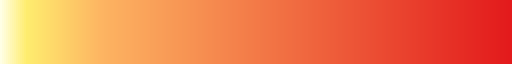

In [16]:
colors = [(0.0, "#ffffe5"), (0.05, "#ffed6f"), (0.2, "#fdb462"), (1, "#e31a1c")] 
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
cmap

In [82]:
def motif_perc(df, outputfile=None):
	fig, ax = plt.subplots(1, 2, figsize=(10, 1.5), gridspec_kw={'width_ratios': [30,1]})
	g = sns.heatmap(data=df, cmap=cmap, ax=ax[0], cbar=True, cbar_ax=ax[1])	
	g.set_xticklabels(g.get_xticklabels(), rotation=30, fontsize=bfontsize, ha="right")
	g.set_yticklabels([f"{p.capitalize()}\n(n={tots[p]})" for p in ps], rotation=0, 
					  fontsize=bfontsize, ha="center")
	g.yaxis.set_tick_params(pad=50)
	
	ax[1].set_ylabel("TREs (%)", fontsize=bfontsize, labelpad=10)
	ax[1].tick_params(axis="y", labelsize=sfontsize)
	
	fig.subplots_adjust(wspace=0.1)
	if outputfile:
		plt.savefig(outputfile, bbox_inches="tight", transparent=True) 

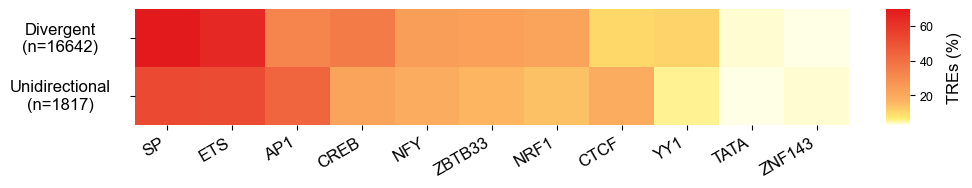

In [83]:
outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig13a.pdf"
motif_perc(df_perc_sorted, outputfile)

# Motif distribution

In [25]:
revs = {}
for motif in motifs:
	revs[motif] = True if motif in ["YY1"] else False

In [33]:
df_hits[p].head(2)

,chr,start,end,start_untrimmed,end_untrimmed,motif_name,hit_coefficient,hit_coefficient_global,hit_similarity,hit_correlation,hit_importance,hit_importance_sq,strand,peak_name,peak_id,motif
0,chr1,906672,906680,906657,906687,pos_patterns.pattern_1,29.597685,0.000130,0.930294,0.930294,0.058670,0.000521,+,chr1_906699_907200,0,ETS
1,chr1,906736,906744,906721,906751,pos_patterns.pattern_1,0.975404,0.000004,0.774990,0.774990,0.018025,0.000060,+,chr1_906699_907200,0,ETS


In [39]:
p = "unidirectional"
peak_info = {}
for d in ds:
	b = pybedtools.BedTool(f"{PROJECT_DIR_d}bed_plot/{s}_{p}_{d}.bed")
	for i in b:
		peak_info["_".join(i.fields[:3])] = (int(i.fields[-3]), i.fields[-1])

In [59]:
# Get the distance from motif center to prominent TSSs of unidirectional elements, and corresponding orientation
# For distance, set the sign to make sure the positive values indicate the motif is downstream of the TSS while negative values indicate the motif is upstream of the TSS for easier interpretation

results = []
for motif in motifs:
	df = df_hits[p][df_hits[p]["motif"]==motif]
	for index, row in df.iterrows():
		chrom, motif_start, motif_end, motif_sign, peak_name = row["chr"], row["start"], row["end"], row["strand"], row["peak_name"]
		motif_center = (motif_start+motif_end)//2
		tss, sign = peak_info[peak_name]
		if sign == "+":
			fwdTSS, revTSS = tss, np.nan
		else:
			fwdTSS, revTSS = np.nan, tss

		if revs[motif]:
			motif_sign = "-" if motif_sign == "+" else "+"
		
		if not np.isnan(fwdTSS):
			fwdD = motif_center - fwdTSS
			fwdO = "Same orientation" if motif_sign == "+" else "Opposite orientation"
			label = "maxTSS" if sign == "+" else "minTSS"
			results.append([motif, chrom, motif_start, motif_end, fwdD, fwdO, label])
			
		if not np.isnan(revTSS):
			revD = revTSS - motif_center
			revO = "Same orientation" if motif_sign == "-" else "Opposite orientation"
			label = "minTSS" if sign == "+" else "maxTSS"
			results.append([motif, chrom, motif_start, motif_end, revD, revO, label])

df_info = pd.DataFrame(results, columns=["motif", "chrom", "motif_start", "motif_end", 
										 "distance", "orientation", "TSS_type"
										])
df_info.head(2)

,motif,chrom,motif_start,motif_end,distance,orientation,TSS_type
0,SP,chr1,3910963,3910972,-18,Same orientation,maxTSS
1,SP,chr1,6157936,6157945,-51,Same orientation,maxTSS


In [47]:
task = "counts"
modisco_path = f"{PROJECT_DIR_o}procapnet/modisco_out/{s}/strand_merged_umap/merged/{task}_modisco_results.hd5"
patterns_IDs = [motifs[motif] for motif in motifs]
cwms = call_motifs_script.load_motif_cwms(modisco_path, {"pos_patterns": patterns_IDs})
cwms_list = list(cwms["pos_patterns"].values())

In [48]:
def plot_motif_on_ax(array, ax, rev=False, fix_appearance=True):
	assert len(array.shape) == 2 and array.shape[-1] == 4, array.shape
	# reformat cwm to what logomaker expects
	df = pd.DataFrame(array, columns=['A', 'C', 'G', 'T'])
	
	def reverse_complement(df):
		# Reverse the order of the rows
		df_rev = df.iloc[::-1].reset_index(drop=True)
		# Swap the columns to their complementary bases
		df_rev.columns = ['T', 'G', 'C', 'A']
		return df_rev
	
	if rev:
		df = reverse_complement(df)
	
	# plot motif ("baseline_width=0" removes the y=0 line)
	logo = logomaker.Logo(df, ax=ax, baseline_width=0)
	
	ax.set_ylim(min(df.sum(axis=1).min(), 0), df.sum(axis=1).max())
	
	if fix_appearance:
		# fix appearance to be less terrible
		logo.style_spines(visible=False)
		ax.set_xticks([])
		ax.set_yticks([])
	
	return logo

In [84]:
def get_all_seqlets_distribution(motifs_order, df_info, outputfile, nrows=6, ncols=4):
	fig, ax = plt.subplots(nrows, ncols, figsize=(10, 7), width_ratios=[1, 1]*(ncols//2))
	for n in range(nrows*(ncols//2)):
		row = n % nrows
		if n < nrows:
			col_ranges = [0,1]
		else:
			col_ranges = [2,3]
		
		for col in col_ranges:
			motif_index = col//2*nrows + row
			if n >= len(motifs):
				ax[row, col].remove()
			else:
				motif = motifs_order[motif_index]
				# seqlogo
				if col in [0,2]:
					cwm_to_plot = cwms["pos_patterns"][f"pattern_{motifs[motif]}"]
					cwm_to_plot = call_motifs_script.trim_motif_by_thresh(cwm_to_plot)
					plot_motif_on_ax(cwm_to_plot, ax[row, col], revs[motif])
					title = motif
				# motif distribution
				else:
					df = df_info[df_info["motif"]==motif]
					g = sns.histplot(data=df, x="distance", hue="orientation", 
									 hue_order=["Same orientation", "Opposite orientation"], 
									 palette=["#d73027", "#4575b4"], 
									 stat="percent", 
									 binwidth=5, binrange=(-100, 100),
									 ax=ax[row,col])
					g.spines[["right", "top"]].set_visible(False)
					g.axvline(x=0, ls="--", c="grey")
					
					if row == 0 and col == ncols-1:
						sns.move_legend(ax[row, col], bbox_to_anchor=(1.05,1), loc='upper left', fontsize=10)
						legend = g.get_legend()
						legend.set_title("TSS vs. motif", prop={'size': 10, 'weight': 'bold'})
					else:
						g.legend('',frameon=False)

					g.set_xticks([-100,0,100])
					if (col == 1 and row == nrows-1) or (col == 3 and row == len(motifs)//2-1):
						xlabel = "Distance (bp)"
					else:
						xlabel = ""
						g.set_xticklabels([])
					g.set_xlabel(xlabel, fontsize=bfontsize, fontweight="bold")				
					
					ylabel = "Motifs (%)"
					g.set_ylabel(ylabel, fontsize=bfontsize, fontweight="bold")					

					g.tick_params(labelsize=sfontsize)
					title = f"n={len(df)}"
					
				ax[row, col].set_title(title, fontsize=bfontsize, fontweight="bold")
			
	plt.subplots_adjust(hspace=0.7, wspace=0.5)
	plt.savefig(outputfile, bbox_inches = 'tight', transparent=True) 

In [80]:
# Keep motifs with decent number of instances in unidirectional elements

motifs_order = [# No orientation preference
				"SP", "ETS", "AP1", "NFY", "CREB", "NRF1", "ZBTB33",
				# Orientation prefence
			    "YY1", "TATA", "CTCF", "ZNF143"
                ]

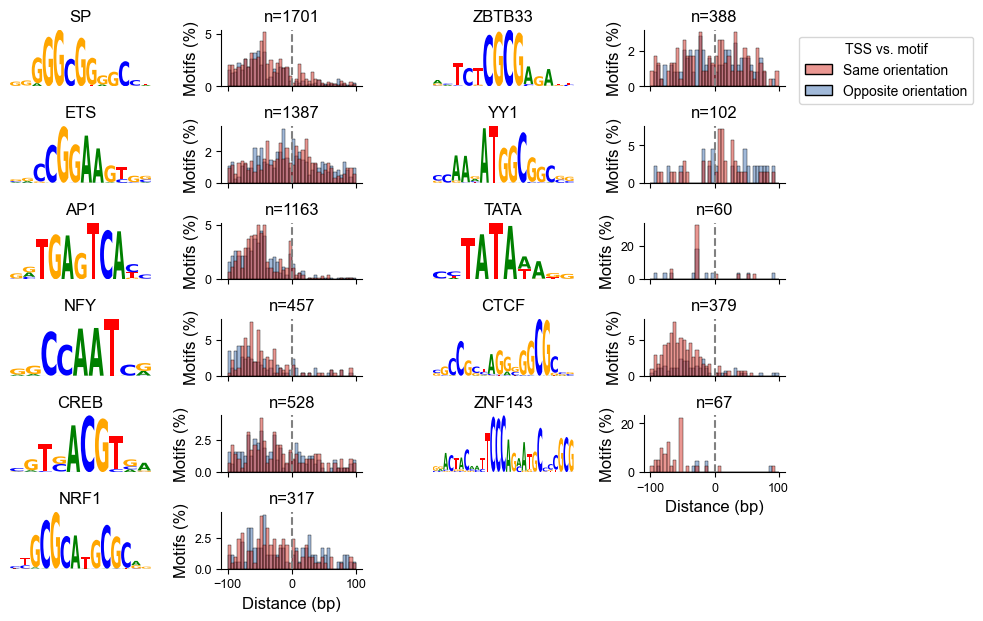

In [85]:
outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig13b.pdf"
get_all_seqlets_distribution(motifs_order, df_info, outputfile)